In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ====================================================
# 1. Load CSV files into DataFrames
# ====================================================
df_assessments       = pd.read_csv("assessments.csv")
df_courses           = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo       = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle        = pd.read_csv("studentVle.csv")
df_vle               = pd.read_csv("vle.csv")

# ====================================================
# 2. Create a Unique Module Identifier
# ====================================================
# Merge code_module and code_presentation into a new column: module_presentation
df_courses["module_presentation"]           = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_courses.code_module, df_courses.code_presentation))
df_assessments["module_presentation"]       = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_assessments.code_module, df_assessments.code_presentation))
df_vle["module_presentation"]               = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_vle.code_module, df_vle.code_presentation))
df_studentInfo["module_presentation"]       = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_studentInfo.code_module, df_studentInfo.code_presentation))
df_studentRegistration["module_presentation"] = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_studentRegistration.code_module, df_studentRegistration.code_presentation))
df_studentVle["module_presentation"]        = list(map(lambda x, y: str(x) + "_" + str(y),
                                                       df_studentVle.code_module, df_studentVle.code_presentation))

print("In Student Info table; \n# of rows: {} \n# of unique student Ids: {} \n"
      "Hence, there are different records for the same student's different module enrolments."
      .format(len(df_studentInfo), len(df_studentInfo.id_student.unique())))
print("\nThis also means that student ID is not really a unique identifier of the table.\n")

# ====================================================
# 3. Consistency Check: Registration vs. Final Result
# ====================================================
# Identify students with a non-null unregistration date (i.e. unregistered students)
temp = df_studentRegistration.loc[
    df_studentRegistration.date_unregistration.notna(),
    ['id_student', 'module_presentation', 'date_unregistration']
]

# Merge the registration info with student info on id_student and module_presentation
temp_merge = pd.merge(df_studentInfo, temp,
                      on=['id_student', 'module_presentation'],
                      how='left')

# Check for inconsistencies: if a student unregistered, final_result must be "Withdrawn"
inconsistencies = temp_merge.loc[
    temp_merge.date_unregistration.notna() & (temp_merge.final_result != 'Withdrawn')
]
print("Inconsistencies between registration and final_result (if any):")
print(inconsistencies)

# ====================================================
# 4. Feature Aggregation
# ====================================================
# 4.1 Count the total number of assessments per module (grouped by code_module and code_presentation)
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# 4.2 Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# 4.3 Compute the average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()
    .reset_index()
    .rename(columns={"score": "score"})
)

# 4.4 Sum total VLE clicks for each student
df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# ====================================================
# 5. Merge DataFrames to Create the Analysis Dataset
# ====================================================
# Merge total assessments into studentInfo based on code_module and code_presentation
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how='left'
)

# Merge attempted assessments count (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how='left'
)

# Merge average score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how='left'
)

# Merge total VLE clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how='left'
)

# Fill missing values with 0 for count/sum fields
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"]           = df_merged["total_assessments"].fillna(0)
df_merged["score"]                       = df_merged["score"].fillna(0)
df_merged["total_vle_clicks"]            = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment completion ratio safely (avoiding division by zero)
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# ====================================================
# 6. Create Binary Target: Withdrawn vs. Not Withdrawn
# ====================================================
# Instead of filtering out withdrawn students, we keep all records and define:
#   target = 1 if final_result is "Withdrawn", else 0.
df_merged["target"] = df_merged["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# ====================================================
# 7. Final DataFrame for Modeling
# ====================================================
# Optionally, rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# Select relevant features along with the new target variable
df_final = df_merged[
    [
        "id_student",
        "code_module",            # module feature
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))

# ====================================================
# 8. Train/Test Split for Modeling
# ====================================================
# Optionally drop the student ID since it's not needed for modeling
df_model = df_final.drop(columns=["id_student"])

# Perform a stratified split so that the target distribution is maintained
train_df, test_df = train_test_split(
    df_model, 
    test_size=0.3, 
    random_state=42, 
    stratify=df_model["target"]
)

print("\nTraining set size:", train_df.shape[0])
print("Test set size:", test_df.shape[0])


In Student Info table; 
# of rows: 32593 
# of unique student Ids: 28785 
Hence, there are different records for the same student's different module enrolments.

This also means that student ID is not really a unique identifier of the table.

Inconsistencies between registration and final_result (if any):
      code_module code_presentation  id_student gender                region  \
2777          BBB             2013J      362907      F     South West Region   
2786          BBB             2013J      365288      F          South Region   
3340          BBB             2013J      554243      F     South West Region   
14625         DDD             2013J      315082      M  West Midlands Region   
14768         DDD             2013J      403052      F      Yorkshire Region   
15577         DDD             2013J      582954      M         London Region   
24057         FFF             2013J      234004      M      Yorkshire Region   
24537         FFF             2013J      523777      

      code_module      score Gender             Region                    HLE  \
12428         CCC   0.000000      M       North Region     Lower Than A Level   
23773         FFF  90.583333      M  South West Region  A Level or Equivalent   
14435         DDD   0.000000      M  South West Region     Lower Than A Level   
710           AAA  35.000000      F           Scotland  A Level or Equivalent   
19086         DDD  94.000000      M           Scotland  A Level or Equivalent   

      Age group  Credit Distribution  assessment_completion_ratio  \
12428      0-35                  120                     0.000000   
23773     35-55                  120                     0.923077   
14435      0-35                  150                     0.000000   
710       35-55                   60                     0.166667   
19086      0-35                  120                     2.285714   

       total_vle_clicks  target  
12428               0.0       1  
23773            3972.0       

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

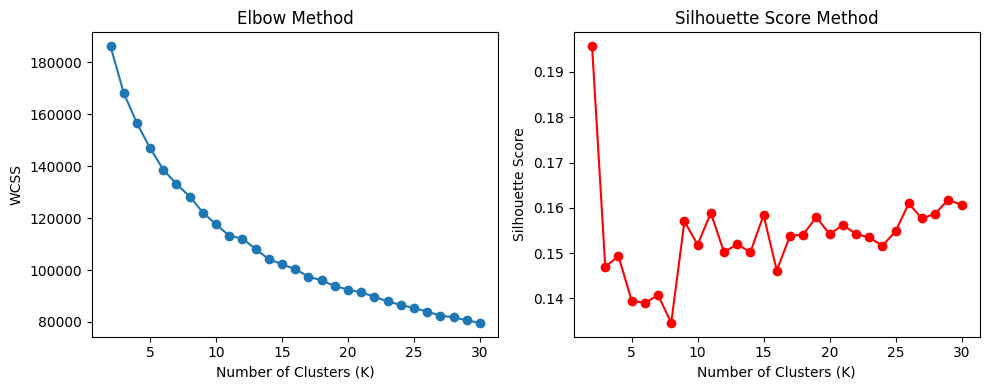

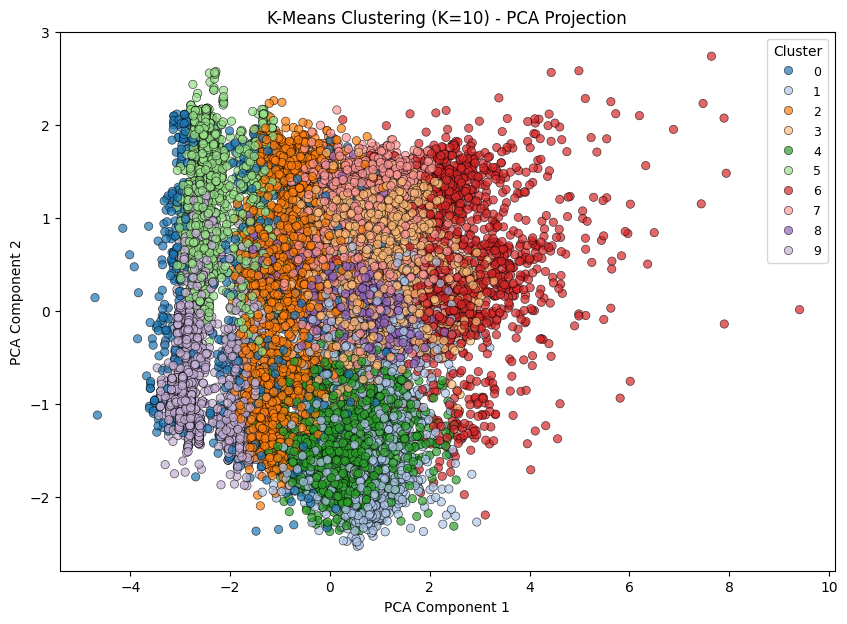

Cluster Means:
         code_module      score    Gender    Region       HLE  Age group  \
Cluster                                                                    
0           3.176196  47.902585  0.561260  5.731622  1.155193   0.222870   
1           1.625000  74.639990  0.375398  5.851513  0.949045   1.043392   
2           2.949304  70.704477  0.661192  5.987504  1.029989   0.260978   
3           3.713569  74.774712  0.980775  5.951519  0.175536   0.063806   
4           1.570143  72.920644  0.010242  6.120732  0.852886   0.000000   
5           3.609802   1.903255  1.000000  5.947220  1.150801   0.252592   
6           3.828042  81.672286  0.745370  5.632937  1.009921   0.564815   
7           4.050199  72.555236  0.980080  5.842629  2.077689   0.242629   
8           5.777845  71.169343  0.011439  5.677905  1.199278   0.354606   
9           2.056185   3.832303  0.000000  5.822080  1.181863   0.265155   

         Credit Distribution  assessment_completion_ratio  total_vle_cli

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# ===========================
# Data Preprocessing on the Training Set
# ===========================
# Use the training set from your previous train/test split
# (Assuming 'train_df' is defined from the split)
df_train = train_df.copy()

# Drop student ID if present (not relevant for clustering)
df_train = df_train.drop(columns=['id_student'], errors='ignore')

# Print the first few rows to check features
print(df_train.head())

# Encode categorical variables
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

# Standardize all features for clustering
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train)

# ===========================
# Finding Optimal K (Elbow & Silhouette Methods)
# ===========================
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

K_range = range(2, 31)  # Trying K from 2 to 30 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_train_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS
    silhouette_scores.append(silhouette_score(df_train_scaled, cluster_labels))

# Plot the Elbow Method results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method")

# Plot the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")
plt.tight_layout()
plt.show()

# ===========================
# Applying K-Means with Optimal K
# ===========================
optimal_k = 10  # Choose optimal K based on the above plots
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_train['Cluster'] = kmeans.fit_predict(df_train_scaled)

# ===========================
# Visualizing Clusters using PCA
# ===========================
pca = PCA(n_components=2)
df_train_pca = pca.fit_transform(df_train_scaled)
df_train['PCA1'] = df_train_pca[:, 0]
df_train['PCA2'] = df_train_pca[:, 1]

plt.figure(figsize=(10, 7))
scatter = sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', 
    data=df_train, palette="tab20", alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (K={optimal_k}) - PCA Projection")
# Adjust legend font size for readability
legend = scatter.legend_
for t in legend.texts:
    t.set_fontsize(9)
plt.show()

# ===========================
# Display Cluster Statistics
# ===========================
print("Cluster Means:")
print(df_train.groupby('Cluster').mean())


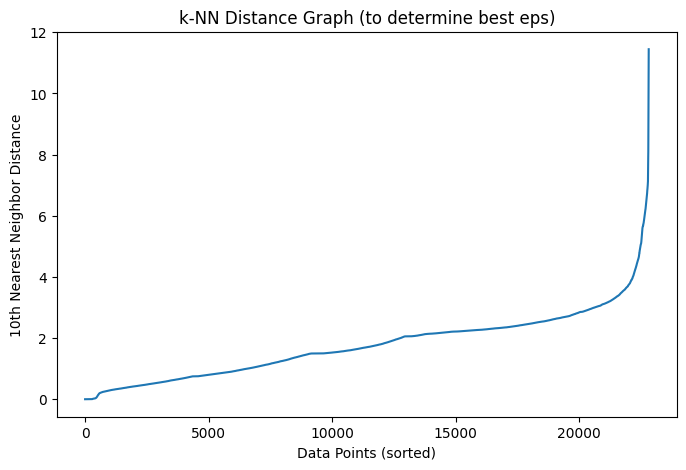

Training set: Number of Clusters found by DBSCAN: 16
Training set: Number of noise points (outliers): 332


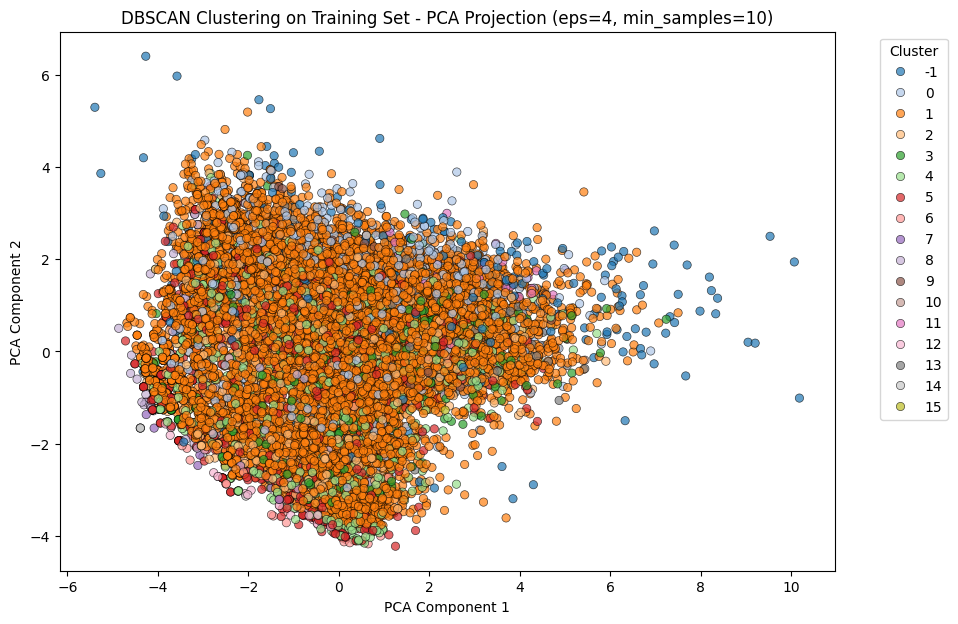

Test set: Number of Clusters assigned by DBSCAN: 6
Test set: Number of noise points (outliers): 8065


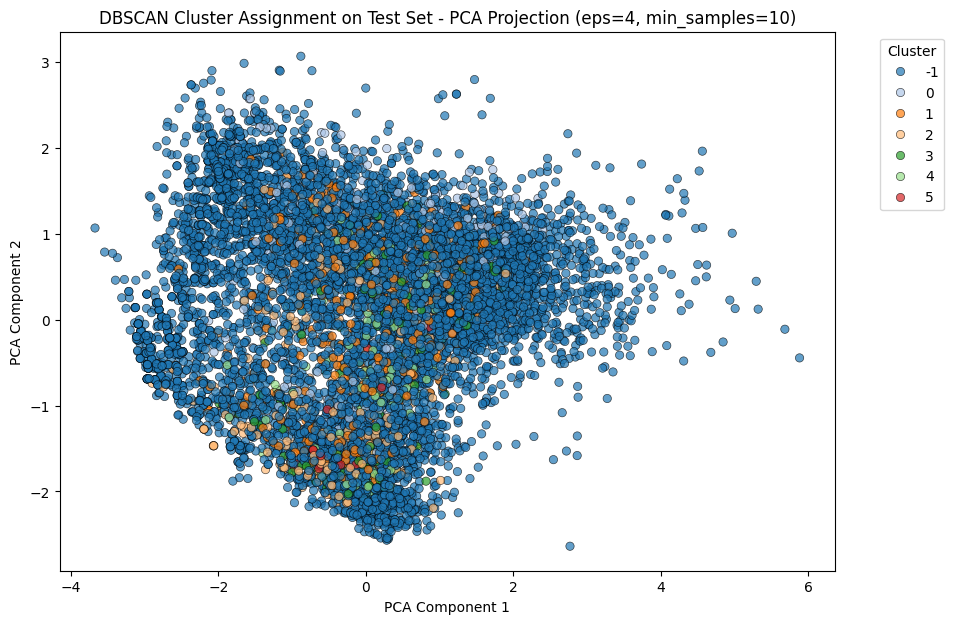

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances_argmin_min

# ===========================
# DBSCAN on Training Set
# ===========================

# Use the training set from your train/test split
df_for_dbscan = train_df.copy()

# Remove 'Cluster' column if present
df_for_dbscan = df_for_dbscan.drop(columns=['Cluster'], errors='ignore')

# One-Hot Encode the categorical features
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module']
df_for_dbscan_encoded = pd.get_dummies(df_for_dbscan, columns=categorical_cols, drop_first=True)

# Re-scale the features using StandardScaler
scaler_dbscan = StandardScaler()
df_dbscan_scaled = scaler_dbscan.fit_transform(df_for_dbscan_encoded)

# ---------------------------
# Optimal eps Determination via k-NN Distance Plot
# ---------------------------
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(df_dbscan_scaled)
distances, indices = nbrs.kneighbors(df_dbscan_scaled)
k_distances = np.sort(distances[:, 9])
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel("10th Nearest Neighbor Distance")
plt.title("k-NN Distance Graph (to determine best eps)")
plt.show()

# ---------------------------
# Applying DBSCAN with chosen eps on Training Set
# ---------------------------
eps_val = 4  # Adjust based on the k-NN plot
dbscan = DBSCAN(eps=eps_val, min_samples=10)
dbscan_labels = dbscan.fit_predict(df_dbscan_scaled)
train_df['DBSCAN_Cluster'] = dbscan_labels

num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise = sum(dbscan_labels == -1)
print(f"Training set: Number of Clusters found by DBSCAN: {num_clusters}")
print(f"Training set: Number of noise points (outliers): {num_noise}")

# Visualize DBSCAN clusters on training set using PCA
pca_dbscan = PCA(n_components=2)
dbscan_pca = pca_dbscan.fit_transform(df_dbscan_scaled)
train_df['PCA1_DBSCAN'] = dbscan_pca[:, 0]
train_df['PCA2_DBSCAN'] = dbscan_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1_DBSCAN', y='PCA2_DBSCAN', hue='DBSCAN_Cluster',
    data=train_df, palette="tab20", alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"DBSCAN Clustering on Training Set - PCA Projection (eps={eps_val}, min_samples=10)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# ===========================
# DBSCAN: Apply to Test Set
# ===========================

# Preprocess the test set: one-hot encode and scale using the same parameters
df_test_for_dbscan = test_df.copy()
df_test_for_dbscan = df_test_for_dbscan.drop(columns=['Cluster'], errors='ignore')

# One-hot encode using the same categorical columns; then align to training columns
df_test_for_dbscan_encoded = pd.get_dummies(df_test_for_dbscan, columns=categorical_cols, drop_first=True)
df_test_for_dbscan_encoded = df_test_for_dbscan_encoded.reindex(columns=df_for_dbscan_encoded.columns, fill_value=0)

# Scale test data using the same scaler from training
df_test_dbscan_scaled = scaler_dbscan.transform(df_test_for_dbscan_encoded)

# --- Assign DBSCAN cluster labels to test samples ---
# Since DBSCAN does not support prediction, we assign clusters based on nearest centroids computed from the training set.

# Compute centroids for each valid (non-noise) cluster from training data
valid_clusters = np.unique(dbscan_labels[dbscan_labels != -1])
centroids = {}
for cluster in valid_clusters:
    mask = (dbscan_labels == cluster)
    centroids[cluster] = df_dbscan_scaled[mask].mean(axis=0)

if len(centroids) > 0:
    centroid_array = np.vstack(list(centroids.values()))
    cluster_labels_list = list(centroids.keys())
else:
    centroid_array = np.empty((0, df_dbscan_scaled.shape[1]))
    cluster_labels_list = []

def assign_dbscan_cluster(sample, centroid_array, cluster_labels_list, threshold):
    if centroid_array.shape[0] == 0:
        return -1
    sample = sample.reshape(1, -1)
    closest, distances = pairwise_distances_argmin_min(sample, centroid_array)
    if distances[0] <= threshold:
        return cluster_labels_list[closest[0]]
    else:
        return -1

test_dbscan_labels = np.array([
    assign_dbscan_cluster(sample, centroid_array, cluster_labels_list, threshold=eps_val)
    for sample in df_test_dbscan_scaled
])
test_df['DBSCAN_Cluster'] = test_dbscan_labels

num_clusters_test = len(set(test_dbscan_labels)) - (1 if -1 in test_dbscan_labels else 0)
num_noise_test = sum(test_dbscan_labels == -1)
print(f"Test set: Number of Clusters assigned by DBSCAN: {num_clusters_test}")
print(f"Test set: Number of noise points (outliers): {num_noise_test}")

# Visualize DBSCAN cluster assignments on test set using PCA (using the same PCA model fitted on training data)
dbscan_pca_test = pca_dbscan.transform(df_test_dbscan_scaled)
test_df['PCA1_DBSCAN'] = dbscan_pca_test[:, 0]
test_df['PCA2_DBSCAN'] = dbscan_pca_test[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1_DBSCAN', y='PCA2_DBSCAN', hue='DBSCAN_Cluster',
    data=test_df, palette="tab20", alpha=0.7, edgecolor="black"
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"DBSCAN Cluster Assignment on Test Set - PCA Projection (eps={eps_val}, min_samples=10)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Final Results

## Preprocessing

In [11]:
import numpy as np
import pandas as pd

# For modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, roc_auc_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import clone

# ===========================
# 1) Preprocessing using Train/Test Split
# ===========================

# (Assuming you already performed a train/test split and have train_df and test_df)

# Ensure DBSCAN_Cluster is categorical in both training and test sets
train_df['DBSCAN_Cluster'] = train_df['DBSCAN_Cluster'].astype('category')
test_df['DBSCAN_Cluster'] = test_df['DBSCAN_Cluster'].astype('category')

# Define features including DBSCAN cluster and module
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module', 'DBSCAN_Cluster'
]

# Extract features and target from training and test sets
X_train = train_df[features]
y_train = train_df['target']

X_test = test_df[features]
y_test = test_df['target']

# One-Hot Encode Categorical Features in both training and test sets
categorical_cols = ['Gender', 'Region', 'HLE', 'Age group', 'code_module', 'DBSCAN_Cluster']

X_train_encoded = pd.get_dummies(
    X_train, 
    columns=categorical_cols, 
    drop_first=True
)

X_test_encoded = pd.get_dummies(
    X_test, 
    columns=categorical_cols, 
    drop_first=True
)

# Align training and test sets to ensure they have the same dummy variable columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Create Sample Weights by Module from training data
module_counts = train_df['code_module'].value_counts()
train_df['module_weight'] = train_df['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights_train = train_df['module_weight']

# Define Models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, max_depth=3, bootstrap=True, 
        oob_score=True, class_weight='balanced', random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=42),
        n_estimators=100, random_state=42
    )
}

print("Preprocessing complete. Features and models are defined.")


Preprocessing complete. Features and models are defined.


## K-Fold Cross-Validation on training subset

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.base import clone

k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cv_results = {model_name: {'accuracy': [], 'balanced_accuracy': [], 'f1': [], 'auc': []}
              for model_name in models.keys()}

for fold, (train_index, val_index) in enumerate(skf.split(X_train_encoded, y_train), start=1):
    X_cv_train = X_train_encoded.iloc[train_index]
    X_cv_val   = X_train_encoded.iloc[val_index]
    y_cv_train = y_train.iloc[train_index]
    y_cv_val   = y_train.iloc[val_index]
    w_cv_train = sample_weights_train.iloc[train_index]
    w_cv_val   = sample_weights_train.iloc[val_index]
    
    print(f"\n===== Cross-Validation Fold {fold} =====")
    
    for model_name, model in models.items():
        # Clone the model so each fold starts fresh
        clf = clone(model)
        clf.fit(X_cv_train, y_cv_train, sample_weight=w_cv_train)
        
        y_cv_pred = clf.predict(X_cv_val)
        y_cv_proba = clf.predict_proba(X_cv_val)[:, 1]  # for AUC
        
        # Compute metrics
        acc  = accuracy_score(y_cv_val, y_cv_pred)
        bal_acc = balanced_accuracy_score(y_cv_val, y_cv_pred)
        f1   = f1_score(y_cv_val, y_cv_pred)
        auc  = roc_auc_score(y_cv_val, y_cv_proba, sample_weight=w_cv_val)
        
        cv_results[model_name]['accuracy'].append(acc)
        cv_results[model_name]['balanced_accuracy'].append(bal_acc)
        cv_results[model_name]['f1'].append(f1)
        cv_results[model_name]['auc'].append(auc)
        
        print(f"\nModel: {model_name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        
print("\n===== Cross-Validation Summary =====")
for model_name in models.keys():
    avg_acc = np.mean(cv_results[model_name]['accuracy'])
    avg_bal_acc = np.mean(cv_results[model_name]['balanced_accuracy'])
    avg_f1 = np.mean(cv_results[model_name]['f1'])
    avg_auc = np.mean(cv_results[model_name]['auc'])
    
    print(f"\n{model_name} Averages (k={k} folds):")
    print(f"Accuracy: {avg_acc:.4f}")
    print(f"Balanced Accuracy: {avg_bal_acc:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")
    print(f"AUC: {avg_auc:.4f}")



===== Cross-Validation Fold 1 =====

Model: Decision Tree
Accuracy: 0.8190
Balanced Accuracy: 0.8270
F1 Score: 0.7449
AUC: 0.8810

Model: Random Forest
Accuracy: 0.8103
Balanced Accuracy: 0.7991
F1 Score: 0.7164
AUC: 0.8917

Model: AdaBoost
Accuracy: 0.8089
Balanced Accuracy: 0.8220
F1 Score: 0.7364
AUC: 0.8451

===== Cross-Validation Fold 2 =====

Model: Decision Tree
Accuracy: 0.8094
Balanced Accuracy: 0.8254
F1 Score: 0.7394
AUC: 0.8851

Model: Random Forest
Accuracy: 0.8155
Balanced Accuracy: 0.7994
F1 Score: 0.7188
AUC: 0.8948

Model: AdaBoost
Accuracy: 0.8037
Balanced Accuracy: 0.8185
F1 Score: 0.7314
AUC: 0.8480

===== Cross-Validation Fold 3 =====

Model: Decision Tree
Accuracy: 0.7949
Balanced Accuracy: 0.8110
F1 Score: 0.7218
AUC: 0.8595

Model: Random Forest
Accuracy: 0.7870
Balanced Accuracy: 0.7733
F1 Score: 0.6832
AUC: 0.8760

Model: AdaBoost
Accuracy: 0.7901
Balanced Accuracy: 0.8044
F1 Score: 0.7144
AUC: 0.8276

===== Cross-Validation Fold 4 =====

Model: Decision Tree

## Perf on entire training dataset

In [14]:
# 4) C: Training performance on the entire training subset
training_scores = {}

for model_name, model in models.items():
    # Fit on all training data (using the encoded features)
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights_train)
    
    y_train_pred = clf.predict(X_train_encoded)
    y_train_proba = clf.predict_proba(X_train_encoded)[:, 1]
    
    acc_train = accuracy_score(y_train, y_train_pred)
    bal_acc_train = balanced_accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_proba, sample_weight=sample_weights_train)
    
    training_scores[model_name] = {
        'accuracy': acc_train,
        'balanced_accuracy': bal_acc_train,
        'f1': f1_train,
        'auc': auc_train
    }

print("\n===== Training Performance on Entire Training Subset =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {training_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {training_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {training_scores[model_name]['f1']:.4f}")
    print(f"AUC: {training_scores[model_name]['auc']:.4f}")



===== Training Performance on Entire Training Subset =====

Decision Tree:
Accuracy: 0.8051
Balanced Accuracy: 0.8223
F1 Score: 0.7351
AUC: 0.8746

Random Forest:
Accuracy: 0.8093
Balanced Accuracy: 0.7993
F1 Score: 0.7163
AUC: 0.8852

AdaBoost:
Accuracy: 0.7996
Balanced Accuracy: 0.8165
F1 Score: 0.7281
AUC: 0.8374


## Perf on holdout

In [16]:
# 5) D: Validation (Holdout) Performance
validation_scores = {}

for model_name, model in models.items():
    # Refit each model on the entire training set
    clf = clone(model)
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights_train)
    
    y_val_pred = clf.predict(X_test_encoded)
    y_val_proba = clf.predict_proba(X_test_encoded)[:, 1]
    
    acc_val = accuracy_score(y_test, y_val_pred)
    bal_acc_val = balanced_accuracy_score(y_test, y_val_pred)
    f1_val = f1_score(y_test, y_val_pred)
    auc_val = roc_auc_score(y_test, y_val_proba)
    
    validation_scores[model_name] = {
        'accuracy': acc_val,
        'balanced_accuracy': bal_acc_val,
        'f1': f1_val,
        'auc': auc_val
    }

print("\n===== Final Holdout (Validation) Performance =====")
for model_name in models.keys():
    print(f"\n{model_name}:")
    print(f"Accuracy: {validation_scores[model_name]['accuracy']:.4f}")
    print(f"Balanced Accuracy: {validation_scores[model_name]['balanced_accuracy']:.4f}")
    print(f"F1 Score: {validation_scores[model_name]['f1']:.4f}")
    print(f"AUC: {validation_scores[model_name]['auc']:.4f}")
    
    # Optionally, display the confusion matrix on the holdout set
    clf = clone(models[model_name])
    clf.fit(X_train_encoded, y_train, sample_weight=sample_weights_train)
    y_val_pred2 = clf.predict(X_test_encoded)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_val_pred2))



===== Final Holdout (Validation) Performance =====

Decision Tree:
Accuracy: 0.8095
Balanced Accuracy: 0.8258
F1 Score: 0.7398
AUC: 0.8742
Confusion Matrix:
[[5267 1464]
 [ 399 2648]]

Random Forest:
Accuracy: 0.8098
Balanced Accuracy: 0.8023
F1 Score: 0.7194
AUC: 0.8885
Confusion Matrix:
[[5534 1197]
 [ 663 2384]]

AdaBoost:
Accuracy: 0.8018
Balanced Accuracy: 0.8187
F1 Score: 0.7308
AUC: 0.8329
Confusion Matrix:
[[5209 1522]
 [ 416 2631]]
